This is an implementation of the PyLevy distribution in our work to fit absorption lines.

Note that you have to install PyLevy first. https://github.com/josemiotto/pylevy 
I run this notebook from the master-directory which is why there is some circuitous path stuff for reading in the catalog tables and spectra. Note that the main workhorse from pylevy gives a distribution only for alpha between 0.5 and 2.0. 

In [108]:
from levy import levy
%matplotlib inline

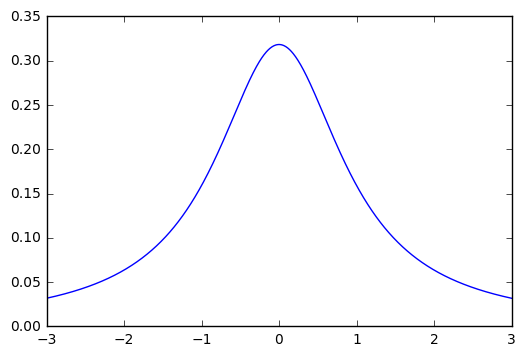

In [3]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-3,3,1000)
alpha = 1.0
beta = 0.0
plt.plot(x,levy(x, alpha, beta, mu=0.0, sigma=1.0, cdf=False, par=0))

In [4]:
from astropy.modeling.models import custom_model
def sine_model(x, amplitude=1., frequency=1.):
    return amplitude * np.sin(2 * np.pi * frequency * x)
def sine_deriv(x, amplitude=1., frequency=1.):
     return 2 * np.pi * amplitude * np.cos(2 * np.pi * frequency * x)
SineModel = custom_model(sine_model, fit_deriv=sine_deriv)

In [5]:
model = SineModel(amplitude=2.)
model(0.25)

2.0

In [63]:
def levy_model(x, alpha=1.0, mu=0.0, sigma=1.0, c=1.0):
    return c*levy(x, alpha, 0.0, mu=mu, sigma=sigma, cdf=False, par=0)

In [ ]:
def levy_model_2(x, alpha=1.0, mu=0.0, sigma=1.0, c=1.0):
    x_int = x-mu
    p = 1/(2*np.pi) [[\int_{-\infty}^{+\infty} dt]] np.exp(-i*x - np.abs(sigma*t)^alpha)
    p_scale = c*p


In [7]:
model_2 = LevyModel()
model_2(1.0)

0.1591550130642686

In [8]:
from astropy.modeling import models
slope = 1.0
intercept = 10.0
alpha = 0.5
mu = 0.2
sigma = 0.25
c = 30.0

result = models.Linear1D(slope=slope, intercept=intercept)-LevyModel(alpha=alpha, mu=mu, sigma=sigma, c=c)
result2 = models.Linear1D(slope=slope, intercept=intercept)-LevyModel(alpha=alpha+0.5, mu=mu, sigma=sigma, c=c)
result3 = models.Linear1D(slope=slope, intercept=intercept)-LevyModel(alpha=alpha+1.0, mu=mu, sigma=sigma, c=c)

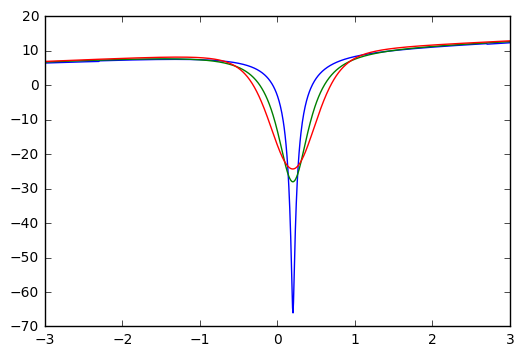

In [9]:
plt.plot(x,result(x))
plt.plot(x,result2(x))
plt.plot(x,result3(x))

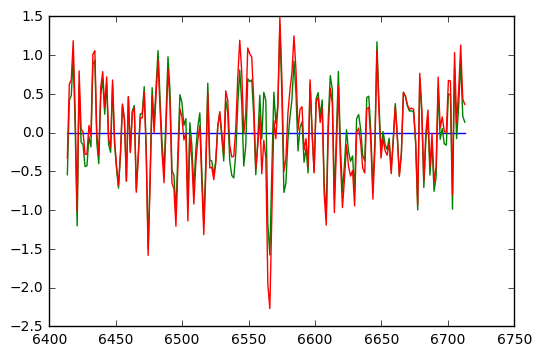

In [107]:
import astropy
from astropy.table import Table, Column, MaskedColumn, vstack 
import numpy as np
import matplotlib.pyplot as plt
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
from astropy.io import fits
import astropy.io.ascii as ascii
from astropy.modeling import models, fitting
from numpy import ones
from numpy.linalg import lstsq
import pandas as pd
from numpy import vstack

def my_line(points, x_vec):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    return m*x_vec + c, m, c
def FWHM(height,norm):
    gam = 1/(np.pi*np.abs(height))
    return gam*norm

from astropy.table import Table
catalog = Table.read('/Volumes/LaCie/WDSpectralFitting/notebooks/DA_with_LP_Mike.dat', format='ascii')

lambda_balmer = np.array([6563, 4861, 4341, 4102, 3970, 3889])
window_size = np.array([150,75,40,30,30,30])
slope_thresholds = [19,55,91,130,200,240]
shift_thresholds = [0,0,0,0,50,50]
    #120 either side for H_alpha,beta,gamma;60,50,40 
    #Main loop
C_coeff_ls = np.zeros(6)
x_center_ls = np.zeros(6)
gamma_ls = np.zeros(6)
alpha_ls = np.zeros(6)
slope_ls = np.zeros(6)
intercept_ls = np.zeros(6)

for index,i in enumerate(catalog):
        index = -7
        #Gets data from file
        directory = "/Volumes/LaCie/WDSpectralFitting/data/"
        filename = directory+catalog['file'][index]

        try:
            data = fits.getdata(filename, 1)
        except:
            print("Missing", filename)
            continue

        all_flux = data['flux']
        all_lambda = 10 ** data['loglam']

        for ind,line in enumerate(lambda_balmer):
            size = window_size[ind]
            #Make the windows for lorentzian fitting
            window = np.where(np.logical_and(all_lambda>= (line - size), all_lambda<= (line + size)))[0]
            #Get an educated guess for C_true
            if not all_flux[window].size:
                continue
            thirds = int(len(all_flux[window])/3)
            left_max = np.max(all_flux[window][:thirds])
            right_max = np.max(all_flux[window][-thirds:])
            left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
            right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

            points = [(left_point,left_max),(right_point,right_max)]
            vert_fix = my_line(points,all_lambda[window])
   
            int_y = all_flux[window]-vert_fix[0]
            fixed_y = int_y*-1
            area = np.trapz(int_y)
            ampl = np.min(int_y)

            left_mean = np.mean(all_flux[window][:thirds])
            right_mean = np.mean(all_flux[window][-thirds:])
            left_lambda = np.mean(all_lambda[window][:thirds])
            right_lambda = np.mean(all_lambda[window][-thirds:])

            points = [(left_lambda,left_mean),(right_lambda,right_mean)]
            vert_shift = my_line(points,all_lambda[window])

            #Define initial guesses
            c_true = area/5.
            mu_true = line
            slope_true = vert_shift[1]
            intercept_true = vert_shift[2]
            sigma_true = FWHM(np.min(all_flux[window]-vert_shift[0]),C_true)/5.
            alpha_true = 1.0
            LevyModel = custom_model(levy_model)
            #print gamma_true
            result = models.Linear1D(slope=slope_true, intercept=intercept_true)-\
                LevyModel(alpha=alpha_true, mu=mu_true, sigma=sigma_true, c=c_true)
            result.alpha_1.bounds = (0.5,2.0)
            result.beta_1.fixed = True
            fit_ls = fitting.LevMarLSQFitter()
            #plt.plot(all_lambda[window], all_flux[window])
            #plt.plot(all_lambda[window], result(all_lambda[window]))
            g = fit_ls(result, all_lambda[window], all_flux[window])
            chi_squ = np.sum((all_flux[window] - (g(all_lambda[window]))**2/(all_flux[window])))
            result_2 = models.Linear1D(slope=slope_true, intercept=intercept_true)-\
                models.Lorentz1D(x_0=mu_true, fwhm=sigma_true*5, amplitude=c_true)
            h = fit_ls(result_2, all_lambda[window], all_flux[window])
            #plt.plot(all_lambda[window], all_flux[window])
            #plt.plot(all_lambda[window], g(all_lambda[window]))
            #plt.plot(all_lambda[window], h(all_lambda[window]))
            plt.plot(all_lambda[window], [0.0]*len(window))
            plt.plot(all_lambda[window], (all_flux[window]-g(all_lambda[window])))
            plt.plot(all_lambda[window], (all_flux[window]-h(all_lambda[window])))
            #plt.xlim(6500,6650)
            break
        break
#            if chi_squ > .3*np.mean(all_flux[window]) or chi_squ > .4*good_WD['S_N'][index]:
#                 plt.figure(figsize=(8,5))
#                 plt.plot(all_lambda[window], all_flux[window], 'ko')
#                 plt.plot(all_lambda[window], -1*g(all_lambda[window]) + vert_fix[0], label='Model')
#                 plt.xlabel('Lambda')
#                 plt.ylabel('Flux')
#                 plt.title('Chi: %f  S_N: %f' %(chi_squ,good_WD['S_N'][index]))
#                 plt.legend(loc=2)
#                 plt.savefig('%f_%f.png' %(index,line))
#                 print chi_squ, good_WD['S_N'][index]
#                count += 1

#            new_centers[ind] = g.x_0.value
#            catalog[ctitle][index] = g.amplitude.value
#            catalog[xtitle][index] = g.x_0.value
#            catalog[gtitle][index] = g.fwhm.value
#            catalog[ytitle][index] = vert_shift[2]
#            catalog[mtitle][index] = vert_shift[1]
#            catalog[chititle][index] = chi_squ
            
            
#             catalog[ctitle][index] = C_coeff_ls[ind]
#             catalog[xtitle][index] = x_center_ls[ind]
#             catalog[gtitle][index] = gamma_ls[ind]
#    print count
#            lambda_balmer = new_centers


In [86]:
catalog

_RAJ2000,_DEJ2000,PMF,SDSS,S_N,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,E_B-V_,pm,GLON,GLAT,SpType,Teff,e_Teff,logg,e_logg,Teff_3D_,e_Teff_3D_,logg_3D_,e_logg_3D_,Mass,e_Mass,Com,Sp,_RA.icrs,_DE.icrs,Plate,MJD,Fiber,RAJ2000,DEJ2000,SNg,f_umag,f_gmag,f_rmag,f_imag,f_zmag,f_pm,pmPA,Ag,GMT,Atype,log_g_,e_log_g_,chi2,m_Nsp,Nsp,q_Nsp,Type,WDcat,DR7,Sloan,Simbad,PMJ,_RA,_DE,file,C0_0,C0_1,C0_2,C0_3,C0_4,C0_5,G0_0,G0_1,G0_2,G0_3,G0_4,G0_5,X0_0,X0_1,X0_2,X0_3,X0_4,X0_5,Y0_0,Y0_1,Y0_2,Y0_3,Y0_4,Y0_5,M0_0,M0_1,M0_2,M0_3,M0_4,M0_5,Chi0_0,Chi0_1,Chi0_2,Chi0_3,Chi0_4,Chi0_5,C1_0,C1_1,C1_2,C1_3,C1_4,C1_5,G1_0,G1_1,G1_2,G1_3,G1_4,G1_5,X1_0,X1_1,X1_2,X1_3,X1_4,X1_5,Y1_0,Y1_1,Y1_2,Y1_3,Y1_4,Y1_5,M1_0,M1_1,M1_2,M1_3,M1_4,M1_5,Chi1_0,Chi1_1,Chi1_2,Chi1_3,Chi1_4,Chi1_5,z,helio_rv
float64,float64,str15,str19,int64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,str5,str6,str5,str5,str2,int64,int64,float64,float64,str6,str4,str6,str5,str5,str6,str2,str2,str8,str8,int64,int64,int64,str10,str10,str5,str15,str15,str15,str15,str15,str2,str5,str5,str19,str13,str4,str5,str4,str4,str4,str2,str2,str2,str3,str5,str6,str15,str9,str10,str21,float64,float64,float64,float64,str18,str16,float64,float64,float64,float64,str14,str14,float64,float64,float64,float64,str13,str14,float64,float64,float64,float64,str16,str17,float64,float64,float64,float64,str18,str18,float64,float64,float64,float64,str13,str13,str22,str23,float64,float64,str18,str18,str21,str23,float64,float64,str18,str18,str18,str18,float64,float64,str18,str18,str19,str20,float64,float64,str20,str19,str23,str23,float64,float64,str22,str22,str18,str19,float64,float64,str18,str18,float64,float64
8.2812,-0.7926,3586-55181-0214,003310.58-004818.55,13,20.65,0.05,19.68,0.02,19.56,0.03,19.55,0.03,19.49,0.06,0.021,1.90,112.7,-63.3,DA,7757,50,6.578,0.142,7762,50,6.390,0.140,0.167,0.0086,--,Sp,8.2812,-0.7926,3586,55181,214,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,DA,--,--,--,--,--,--,--,DA_high_SN_00000.fits,1.3748920378,2.53162829932,2.59124677894,3.95046264348,4.55252797265,4.92655306949,8.66569833452,9.68428914225,9.74675404854,13.1799451232,16.968412995,17.8400972053,6564.27255163,4863.11951266,4341.53985961,4103.66020241,3971.51441166,3891.53180817,83.8038079214,147.814628452,103.89720381,171.824208498,131.420395745,30.7665212578,-0.0123769357462,-0.0294142972973,-0.0225333364249,-0.0402962626622,-0.0313789327573,-0.00606250092604,0.542387406634,1.20373041378,0.549585393411,2.83985427976,4.78810519077,8.62519999546,1.497598456028287,2.6447065596371604,2.66893698663,3.83596926388,4.575793170177965,4.921055203883472,8.474069342877353,9.11555928623103,8.53463265181,14.2767084672,16.85366185553122,17.42805971157696,6564.616180892435,4863.0720658701,4342.37318833,4103.90554246,3971.445084004546,3891.417619294314,43.1367819234673,113.52927724284605,45.0006748384,168.691347703,298.19020326263865,66.3940986804156,-0.0061712129008109715,-0.022358217417311903,-0.00896070263658,-0.0395306818949,-0.0734166638834632,-0.015247649675597824,41.720889007811344,104.95117359834614,157.415793359,148.17887444,145.1428121972432,139.34002001313314,7.59728063713e-05,29.4926864173
40.007,0.3572,3650-55244-0726,024002.92+002050.50,17,20.33,0.05,19.47,0.02,19.31,0.02,19.24,0.02,19.36,0.06,0.030,0.00,170.9,-52.1,DA,7436,45,6.533,0.137,7453,45,6.360,0.140,0.162,0.0084,--,Sp,40.0070,0.3572,3650,55244,726,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,DA,--,--,--,--,--,--,--,DA_high_SN_00001.fits,1.47419269177,3.12656452404,6.54928134983,7.22760745084,8.20914499419,7.50930411046,11.3663197157,13.354966566,11.5708678513,13.4591457313,15.8060339958,10.093006099,6566.75293598,4863.4000952,4343.37917649,4102.23631079,3969.65463484,3891.30181236,166.842450899,414.367391796,286.455172685,278.360052029,344.764346599,468.85245209,-0.0249042855157,-0.083660771362,-0.0635091479799,-0.0647644864824,-0.0834360907019,-0.116800370785,0.451225382229,2.57613748031,2.14266524601,11.19